In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.svm import SVR,SVC
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,confusion_matrix,roc_auc_score,roc_curve,precision_recall_curve,r2_score
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
import shutil
import graphviz
import dtreeviz


In [22]:
# rf寻找最优参数
def rf_best_param(X_train,y_train,n_estimators_range,k=5):
    """默认为5折交叉验证,评价指标为R2"""
    # 设置树的数目范围
    n_estimators_range = n_estimators_range
    cv_scores = []
    # 使用交叉验证
    for n_estimators in n_estimators_range:
        rf = RandomForestClassifier(n_estimators=n_estimators, random_state=0)
        scores = cross_val_score(rf,X_train, y_train, cv=k, scoring='accuracy')  # K折交叉验证 分类问题默认使用accuracy
        cv_scores.append(scores.mean())
    # 选择最优数量的树
    optimal_n_estimators = n_estimators_range[cv_scores.index(max(cv_scores))]
    return optimal_n_estimators

In [23]:
# 存储采样结果CSV文件的路径
sample_csv = r"D:\ArcgisData\pred_tl\pred_table\test\feature_table_result"
# 输出CSV文件的名称
sample_csv_name = "feature_table_result.csv" 
# 随机森林树的范围
n_estimators_range = range(10, 2000, 200)
# 模型存储路径
modle_save_path = r"D:\ArcgisData\pred_tl\pred_table\test\test_modle" 


In [24]:
# 读取CSV文件使用rf训练模型
data = pd.read_csv(os.path.join(sample_csv,sample_csv_name))
print(data.columns)

Index(['亚类', '土属', '土种', '土类', 'TWI5', 'TPI201', 'TPI101', 'TPI11', 'TPI3',
       'TMP', 'SOILQS', 'SLOP', 'PRE', 'NIGTH', 'NDVI', 'DEM', 'CUR', 'ASP',
       'PLCUR', 'POCUR', 'LON', 'LAT', 'PH', 'DL', 'SC2', 'OSJL', 'SOM', 'DZ'],
      dtype='object')


In [25]:
# 特征因子
feature_list = ['TWI5', 'TPI201', 'TPI101', 'TPI11', 'TPI3','TMP', 'SOILQS', 'SLOP', 'PRE', 'NIGTH', 'NDVI', 'DEM', 'CUR', 'ASP','PLCUR', 'POCUR', 'LON', 'LAT', 'PH', 'DL', 'SC2', 'OSJL', 'SOM', 'DZ']
target_label = "土类"

In [26]:
data = data[feature_list+[target_label]]
# 列类型转换
data["SC2_label"] = data.SC2.astype("category").cat.codes
data["DL_label"] = data.DL.astype("category").cat.codes
data["DZ_label"] = data.DZ.astype("category").cat.codes
data["TL_label"] = data.土类.astype("category").cat.codes
data.sample()

,TWI5,TPI201,TPI101,TPI11,TPI3,TMP,SOILQS,SLOP,PRE,NIGTH,...,DL,SC2,OSJL,SOM,DZ,土类,SC2_label,DL_label,DZ_label,TL_label
481,4.05633,-24.627075,-2.326294,0.539551,-0.001953,122.833336,11,37.88848,891.0,0.2,...,4.0,2,133.13527,31.151531,7,黄棕壤,1,2,6,4


In [34]:
# 数据划分
features = ['TWI5', 'TPI201','TMP', 'SLOP','PRE', 'NIGTH', 'NDVI', 'DEM','PH', 'OSJL', 'SOM', 'SC2_label','DL_label', 'DZ_label']
targets = "TL_label"
X = data[features]
y = data[targets]

In [35]:
# 划分训练集和测试集
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
# 寻找最优树的个数
# best_tree = rf_best_param(X_train,y_train,n_estimators_range,5)
best_tree = 110
# best_tree = 10
print(best_tree)

110


In [36]:
rf = RandomForestClassifier(n_estimators=110, random_state=42,max_depth=7)
rf.fit(X_train,y_train)

RandomForestClassifier(max_depth=7, n_estimators=110, random_state=42)

In [37]:
# 查看准确率
y_test_pred= rf.predict(X_test)
y_train_pred = rf.predict(X_train)
r2_test = accuracy_score(y_test,y_test_pred)
r2_train = accuracy_score(y_train,y_train_pred)
print(r2_test,r2_train)

0.9230769230769231 0.9389774601429357


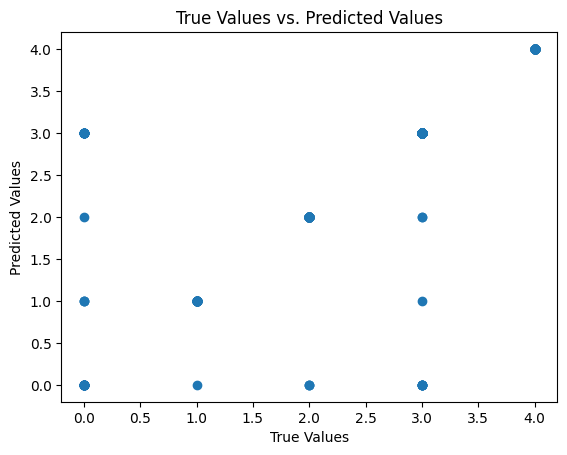

In [38]:
# 预测散点图
plt.scatter(y_test.values, y_test_pred)

# 添加标签和标题
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs. Predicted Values')

# 显示图表
plt.show()

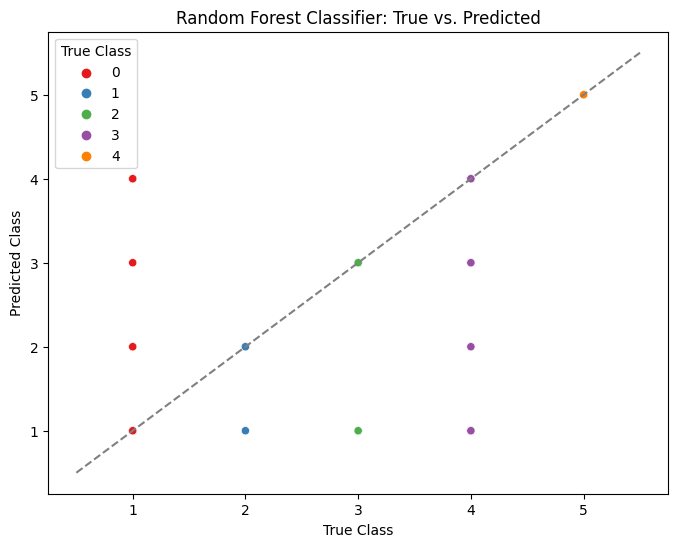

In [39]:
# 创建分类散点图
df =  pd.DataFrame({'True Class': y_test, 'Predicted Class': y_test_pred})
class_names = [1,2,3,4,5]
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='True Class', y='Predicted Class', hue='True Class', palette='Set1')
plt.xlabel('True Class')
plt.ylabel('Predicted Class')
plt.title('Random Forest Classifier: True vs. Predicted')
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)
plt.legend(title='True Class')
plt.plot([-0.5, len(class_names) - 0.5], [-0.5, len(class_names) - 0.5], '--', color='gray')
plt.show()

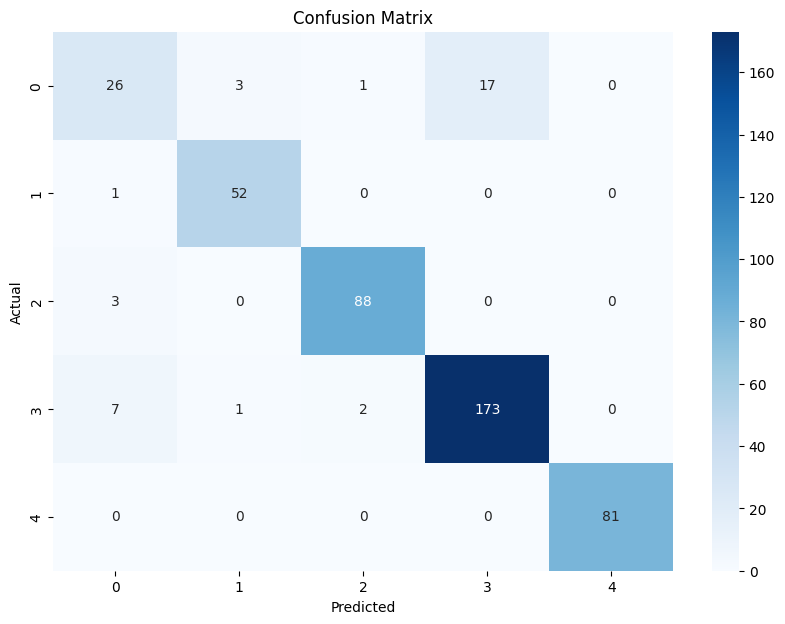

In [40]:
# 绘制混淆矩阵
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='g', cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

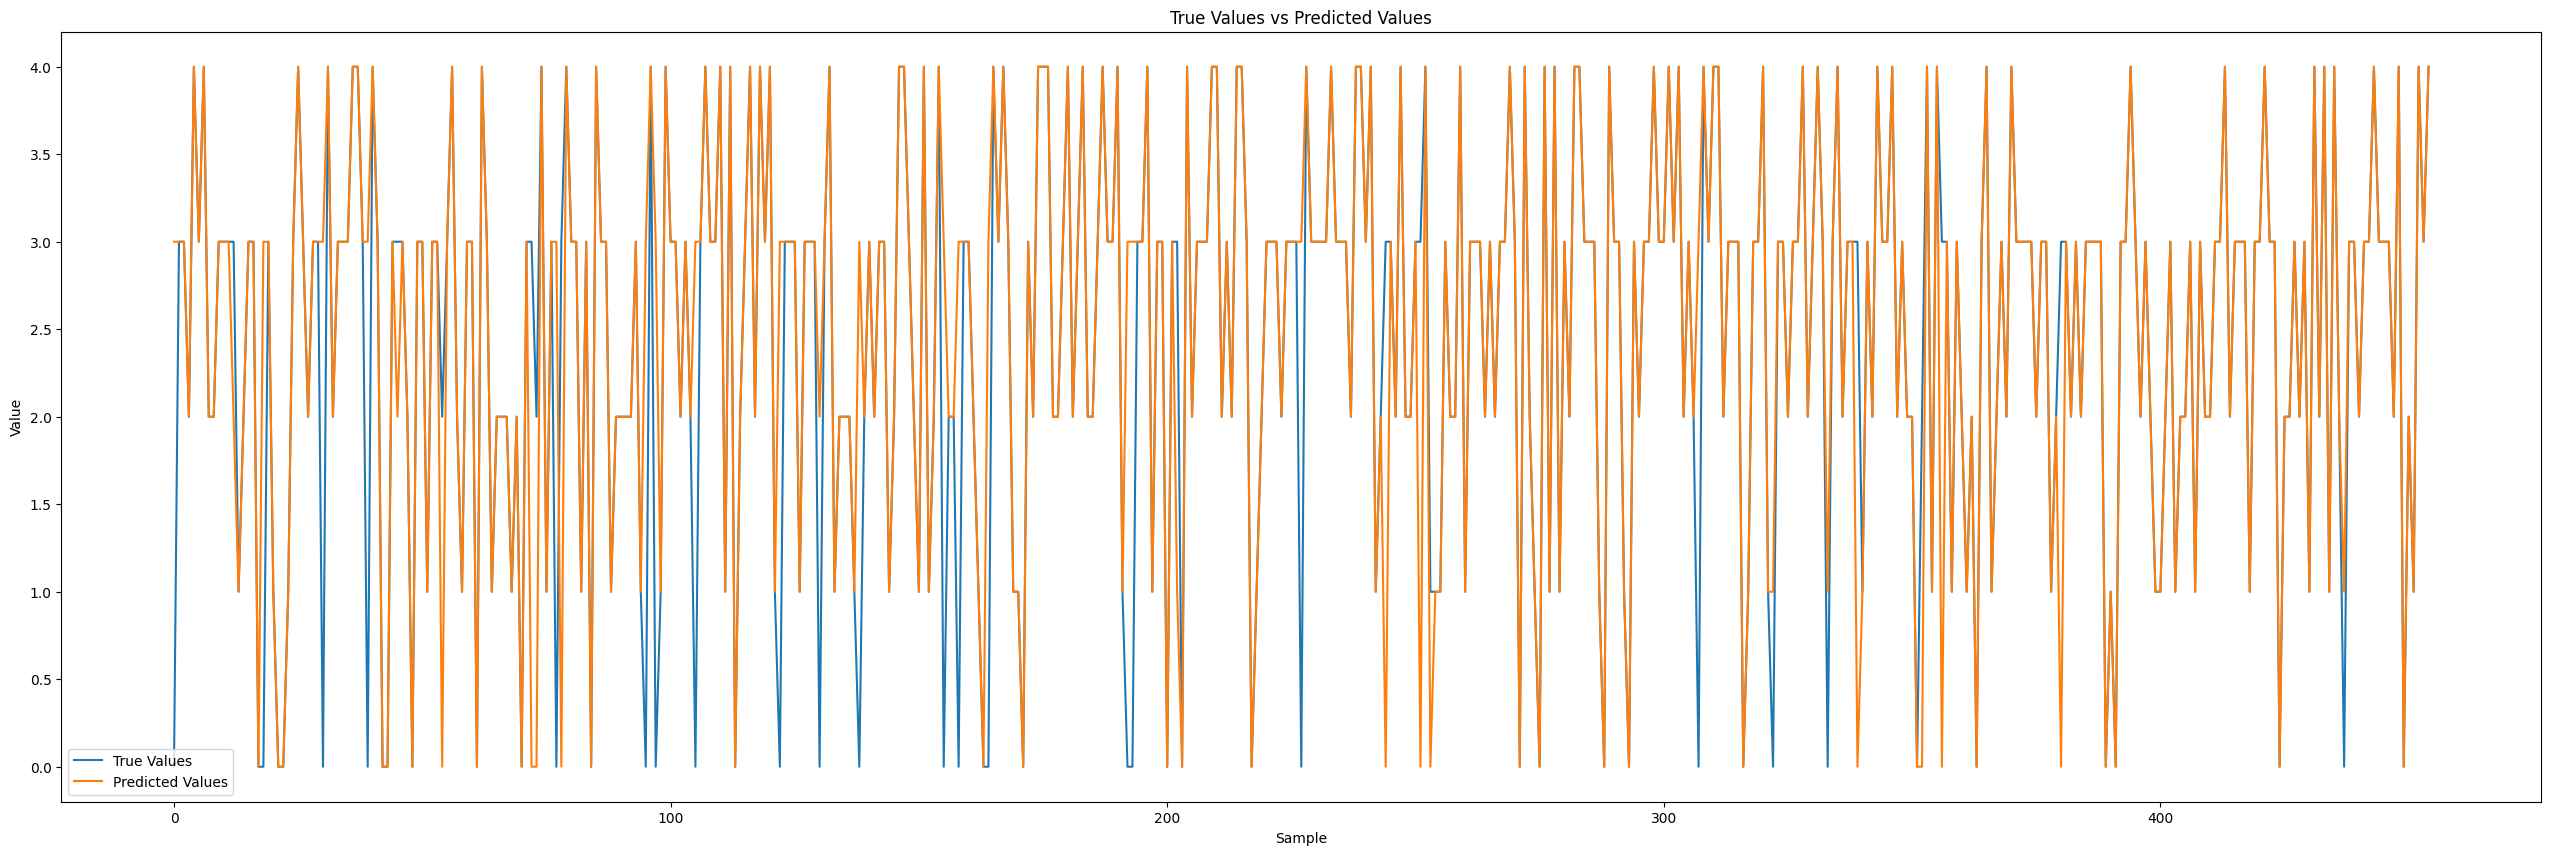

In [41]:
# 创建折线图
plt.figure(figsize=(32,10))
plt.plot(y_test.values, label='True Values')
plt.plot(y_test_pred, label='Predicted Values')

# 图表标题和标签
plt.title('True Values vs Predicted Values')
plt.xlabel('Sample')
plt.ylabel('Value')

# 添加图例
plt.legend()

# 显示图表
plt.show()

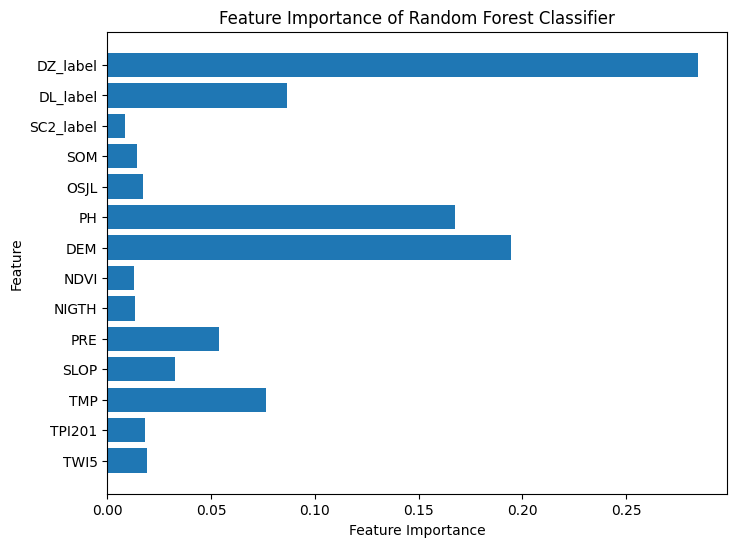

In [42]:
# 特征因子
# 获取特征重要性
feature_importance = rf.feature_importances_

# 创建柱状图
plt.figure(figsize=(8, 6))
plt.barh(range(len(features)), feature_importance, align='center')
plt.yticks(range(len(features)), features)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance of Random Forest Classifier')
plt.show()